# Experiment 1

Checking whether a heap-like graph is actually a heap using a GGNN

In [1]:
%cd ..
%pwd
import wandb
from experiments.heaps import *
from ggnns.graph_level_ggnn import GraphLevelGGNN
from experiments.utils import *
from torch_geometric.data import DataLoader
import matplotlib.pyplot as plt

/home/tekne/Oxford/ATML/Project/ggs-nn-model


In [2]:
def get_data(config):
    if config["graph_kind"] == 'tree':
        graph_generators = [(heap_graph, True)]
    elif config["graph_kind"] == 'linear':
        graph_generators = [(directed_path_graph, True)]
    elif config["graph_kind"] == 'linear+tree':
        graph_generators = [(heap_graph, True), (directed_path_graph, True)]
    else:
        raise ValueError(f"config[\"graph_kind\"] = {config.graph_kind}")

    data = make_heap_test_gnn_datapoints(
        n = config["n_train"] + config["n_test"],
        p_heap = config["p_heap"],
        min_len = config["min_len"],
        max_len = config["max_len"],
        graph_generators = graph_generators,
    )

    training_data = DataLoader(data[:config["n_train"]], batch_size=config["batch_size"])
    testing_data = DataLoader(data[config["n_train"]:], batch_size=config["batch_size"])

    return training_data, testing_data

def evaluate_model(config, **kwargs):
    wandb.init(**kwargs)
    wandb.config = config

    NUM_CLASSES = 2

    model = GraphLevelGGNN(
        annotation_size=1,
        num_layers=config["num_layers"],
        gate_nn=nn.Linear(2 * 1 + config["hidden_size"], 1),
        hidden_size=config["hidden_size"],
        final_layer=nn.Linear(2 * 1 + config["hidden_size"], NUM_CLASSES),
    ).cuda()

    wandb.watch(model)
    wandb.run.summary["model_parameters"] = model.count_parameters()

    opt = torch.optim.Adam(model.parameters(), lr=config["lr"])
    loss = torch.nn.CrossEntropyLoss()

    training_data, testing_data = get_data(config)

    results = train(
        model=model,
        opt=opt,
        training_data=training_data,
        testing_data=testing_data,
        criterion=lambda out, y: loss(out, y),
        checker=lambda out, y: ((torch.argmax(out, dim=-1) == y).sum(), y.shape[0]),
        epochs=config["epochs"],
        logger=wandb
    )

    plt.plot(results["train_loss"], label="Training loss")
    plt.plot(results["test_loss"], label="Testing loss")
    plt.legend()
    plt.show()

    plt.plot(results["train_accuracy"], label="Training accuracy")
    plt.plot(results["test_accuracy"], label="Testing accuracy")
    plt.legend()
    plt.show()

    wandb.finish()

In [3]:
config = {
    "n_train": 1000,
    "n_test": 1000,
    "epochs": 100,
    "lr": 0.01,
    "opimizer": "adam",
    "min_len": 1,
    "max_len": 64,
    "batch_size": 500,
    "p_heap": 0.5,
    "graph_kind": "tree",
    "num_layers": 2,
    "hidden_size": 10,
}

100%|██████████| 100/100 [00:09<00:00, 10.10it/s]


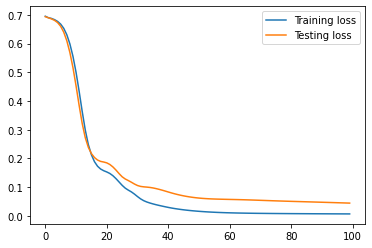

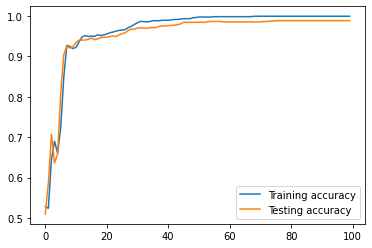

In [4]:
evaluate_model(config, project="ggnn_heap_check")